In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from scipy.ndimage import gaussian_filter1d
from scipy.stats import sem
import SQ_PCA_analysis
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
from sklearn.model_selection import train_test_split
from sklearn import svm
import sklearn
from sklearn import linear_model
import sys
import PCA_decoders
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem



## Instructions to run this file

This file will get us the fig5 and fig 6 of the paper. 

Raw data - .npz files, Allmice_Separatedunits_SQ_Fig5.pkl (these are preprocessed file containing the neural activity for sucrose and quinine trials, along with the trial numbers)


In [2]:
filee = "SQ_raw/Allmice_Separatedunits_SQ_Fig5.pkl"
with open(filee, 'rb') as f:
    eohm_total_S, iohm_total_S, rhm_total_S, eohm_total_Q, iohm_total_Q, rhm_total_Q, timevec, counts_SQ, unitsdiscardedSQ = pickle.load(
        f)

In [3]:
datadir = Path(r'SQ_raw') 
data_list = datadir.rglob('*.npz')
# make a matrix now - trial-averaged and arranged by idx_S and idx_Q
mouse_consider_sq = ["M2498", "M2502"]

neural_S_all = []
neural_Q_all = []
idx_S_all = []
idx_Q_all = []
heatmap_S = np.array([])
heatmap_Q = np.array([])
heatmap_persess = [None]*1
st5sec = int(np.where(timevec <= -5)[0][-1])
ed5sec = int(np.where(timevec >= 5)[0][0])
mousenames = []
trialnumsS = []
trialnumsQ = []
units = []

for data_path in data_list:
    n = data_path.name
    # print(str(n)[:-13])
    if str(n)[:-13] in mouse_consider_sq:
        print(n)
    else:
        continue
    mousenames.append(str(n)[:-4])
    
    f= np.load(str(datadir)+"\\"+n, allow_pickle=True)
    neural_S_all.append(f['arr_0'])#trial * time(799) * neurons for each mouse
    neural_Q_all.append(f['arr_1'])
    trialnumsS.append(len(f['arr_0']))
    trialnumsQ.append(len(f['arr_1']))
    idx_S_all.append(f['arr_2'])
    idx_Q_all.append(f['arr_3'])
    Sarr = np.nanmean(f['arr_0'], axis=0).T
    Qarr = np.nanmean(f['arr_1'], axis=0).T
  

    window = 10
    for i in range(Sarr.shape[1]): 
        Sarr[:,i] = np.sum(Sarr[:,i:i+window], axis = 1)
        Qarr[:,i] = np.sum(Qarr[:,i:i+window], axis=1)
    

    Sarr = SQ_PCA_analysis.calcAvgZscore(Sarr, timevec)
    Qarr = SQ_PCA_analysis.calcAvgZscore(Qarr, timevec)
    print(Sarr.shape)
    units.append(Sarr.shape[0])
   
    if len(heatmap_S) == 0:
        heatmap_S = Sarr[:,st5sec:ed5sec]
        heatmap_Q = Qarr[:,st5sec:ed5sec]
        heatmap_persess[0] = np.hstack((Sarr[:,st5sec:ed5sec],Qarr[:,st5sec:ed5sec]))
    else:
        heatmap_S = np.vstack((heatmap_S,Sarr[:,st5sec:ed5sec]))#gives the z scored neural data for each mouse, neurons*tp
        heatmap_Q = np.vstack((heatmap_Q,Qarr[:,st5sec:ed5sec]))
        heatmap_persess.append(np.hstack((Sarr[:,st5sec:ed5sec],Qarr[:,st5sec:ed5sec])))

M2498_20230421.npz
(55, 799)
M2502_20230421.npz
(54, 799)


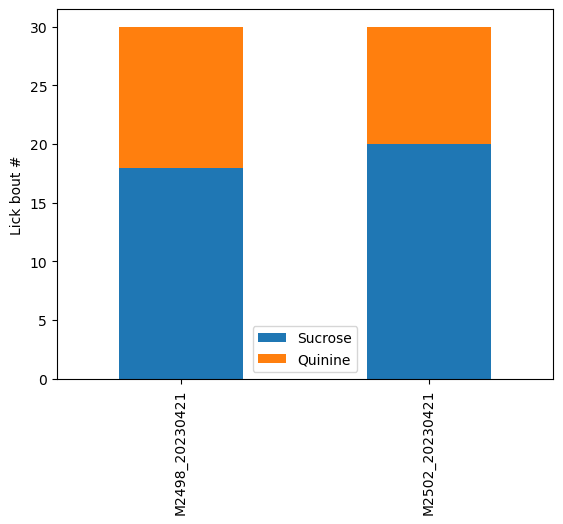

In [ ]:
#Lick bout number per mouse [Extended Data Fig 6b]

df = pd.DataFrame({'Sucrose': trialnumsS,
                   'Quinine':trialnumsQ},
                   index = mousenames
)
df.plot(kind='bar', stacked=True)
plt.ylabel('Lick bout #')
# plt.savefig('output_path.svg')
plt.show()

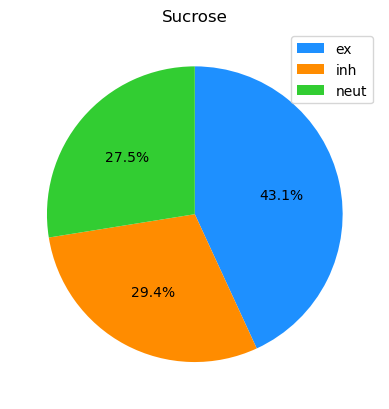

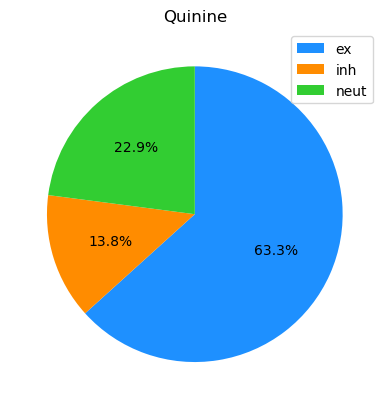

In [ ]:
#To get the PSTH and to get the excited, inhibited and neutral units 

def avg_sem_obtainer(ehm, sig=3):
    ehm = np.array(ehm) #converts to array 
    avg_ehm = gaussian_filter1d(np.mean(ehm, axis=0), sig)
    semm = gaussian_filter1d(sem(ehm, axis=0), sig)
    semm_pos = avg_ehm + semm
    semm_neg = avg_ehm - semm
    return avg_ehm, semm_pos, semm_neg

def unit_psth_plotter(ax,avg_ehm, semm_pos, semm_neg, t, title, trialtype,ylim_manual = [-1.5, 1.5]):
    
    ax.plot(avg_ehm, c='k')
    ax.plot(semm_pos, c='grey')
    ax.plot(semm_neg, c='grey')
    mid = int(avg_ehm.shape[-1]/2)
    ax.axvline(x=mid, c='r')
    ax.set_xlabel('Time')
    ax.set_title(title)
    t_show = np.arange(-5,6,1)
    t = np.round(np.linspace(-5,5, avg_ehm.shape[-1], endpoint=True),2)
    ticknum = len(t_show)
    idx_ticks = []
    for i in range(ticknum):
        idx_ticks.append(np.where(t==t_show[i]))
    idx_ticks = np.array(idx_ticks).squeeze()
    #idx_ticks =np.where(t==t_show)[0] #np.linspace(0,avg_ehm.shape[-1], ticknum)
    ax.set_xticks(idx_ticks)
    ax.set_xticklabels(t_show)
    ax.set_ylim(ylim_manual)
 
    ax.set_ylim(ylim_manual)

def exc_inh_rhm_identifyandplot(heatmap_S,trialtype, savefigs=False):
    unitnum = heatmap_S.shape[0]
    ehm =[]
    ehm_idx = []
    ihm =[]
    ihm_idx = []
    rhm =[]
    rhm_idx = []

    for i in range(unitnum):
        mid = int(heatmap_S.shape[-1]/2)
        
        st = mid 
        
        ed = mid + int(2/0.025)
        z_exc = 1.96
        z_inh = -1.65
        # the idea is to take a sliding window and check if all the values
        # in the sliding window are greater than z=1
        # size of sliding window = 4 (250ms)
        window = 4
        counter = 0
        exc_c = 0
        inh_c = 0
        for j in range(heatmap_S[i,st:ed-4].size):
            comp = heatmap_S[i,st+j:st+j+window]
            if all(c>z_exc for c in comp):
                exc_c+=1
              

            if all(c<z_inh for c in comp):
                inh_c +=1
              
            counter+=1

        if (exc_c>0 and inh_c>0) or (exc_c>0 and inh_c==0):
            ehm.append(heatmap_S[i,:])
            ehm_idx.append(i)
        
        elif inh_c>0 and exc_c==0:
            ihm.append(heatmap_S[i,:])
            ihm_idx.append(i)

        elif counter==heatmap_S[i,st:ed-4].size:
            rhm.append(heatmap_S[i,:])
            rhm_idx.append(i)
        else:
            print()

    total = heatmap_S.shape[0]
    ehmperc = len(ehm)*100/total
    ihmperc = len(ihm)*100/total
    rhmperc = len(rhm)*100/total
    colors = ["dodgerblue", "darkorange", "limegreen"]
    plt.pie([ehmperc, ihmperc, rhmperc], autopct='%1.1f%%', startangle = 90, colors=colors, counterclock=False)
    plt.legend(["ex", "inh", "neut"])
    plt.title(trialtype)
    if savefigs == True:
        plt.savefig("Results_SQ/Non injected/PCA_finalpictures_SQNew/PieCharts/PSTH_unitperc"+trialtype+".svg")
    plt.show()

    return ehm, ihm, rhm, ehm_idx, ihm_idx, rhm_idx

SQ_heatmapPCA = np.hstack((heatmap_S, heatmap_Q))
ehm_S, ihm_S, rhm_S, ehm_idxS, ihm_idxS, rhm_idxS = exc_inh_rhm_identifyandplot(heatmap_S, trialtype="Sucrose", savefigs=False)
ehm_Q, ihm_Q, rhm_Q, ehm_idxQ, ihm_idxQ, rhm_idxQ = exc_inh_rhm_identifyandplot(heatmap_Q, trialtype="Quinine", savefigs=False)




In [ ]:
#this gives the unit tree [Fig 5c]

units_common = []
typesUnits = ["Activation", "Inhibition","Nonresp"]
trialtype=["S", "Q"]
labels=[]
S = [ehm_idxS, ihm_idxS, rhm_idxS]
Q = [ehm_idxQ, ihm_idxQ, rhm_idxQ]

for i in range(3): # sucrose

    for j in range(3): # quinine
        units_common.append(len(np.intersect1d(np.array(S[i]), np.array(Q[j])))*100/(len(ihm_idxS)+len(ehm_idxS)+len(rhm_idxS)))
        labels.append("S_"+typesUnits[i]+"__Q_"+typesUnits[j])

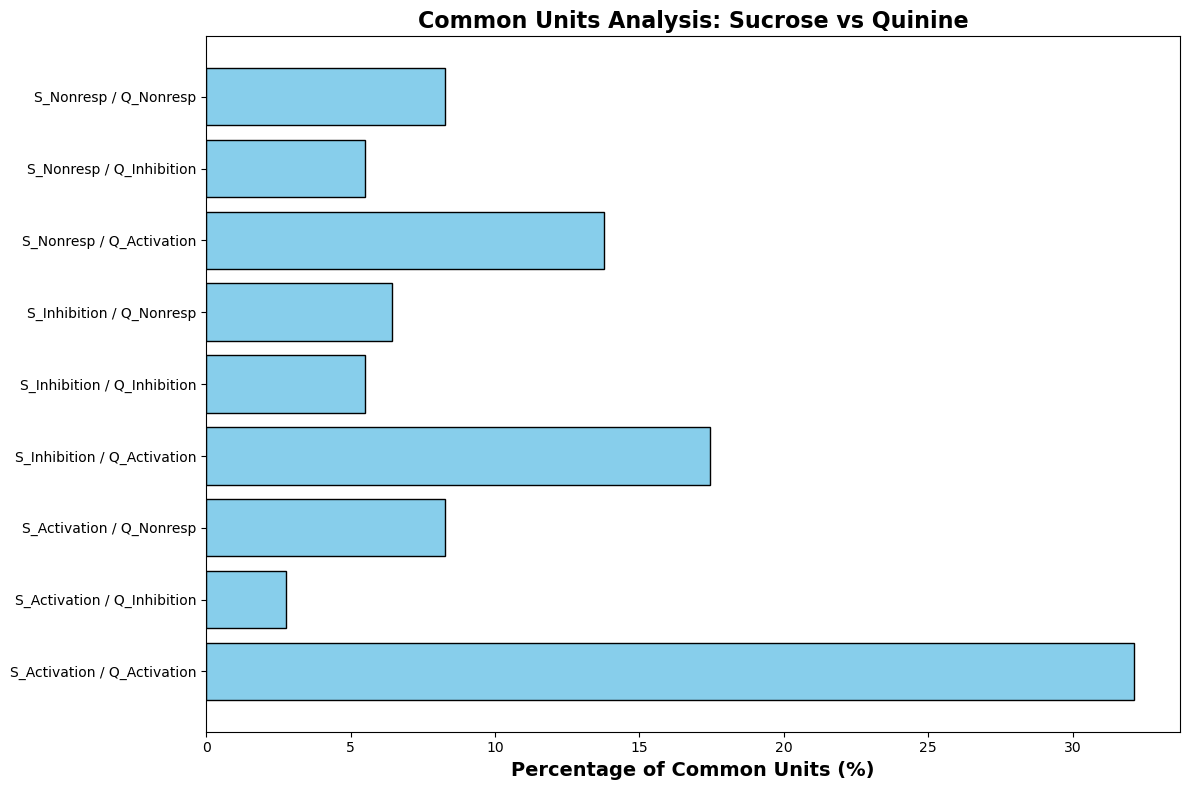

In [ ]:
#this gives the unit tree [Fig 5c]
units_common = []
typesUnits = ["Activation", "Inhibition", "Nonresp"]
trialtype = ["Sucrose", "Quinine"]
labels = []
S = [ehm_idxS, ihm_idxS, rhm_idxS]
Q = [ehm_idxQ, ihm_idxQ, rhm_idxQ]

for i in range(3):  
    for j in range(3):  
        common_units_percentage = len(np.intersect1d(S[i], Q[j])) * 100 / (
            len(ihm_idxS) + len(ehm_idxS) + len(rhm_idxS)
        )
        units_common.append(common_units_percentage)
        labels.append(f"S_{typesUnits[i]} / Q_{typesUnits[j]}")

plt.figure(figsize=(12, 8))
y_positions = np.arange(len(labels))  
plt.barh(y=y_positions, width=units_common, color="skyblue", edgecolor="black")
plt.yticks(y_positions, labels) 
plt.xlabel("Percentage of Common Units (%)", fontsize=14, fontweight="bold")
plt.title("Common Units Analysis: Sucrose vs Quinine", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


0
1


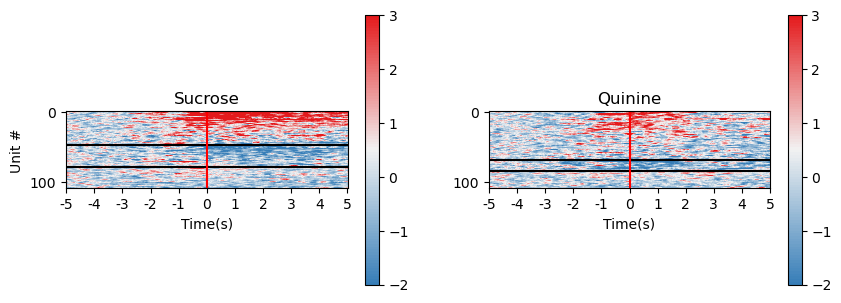

In [ ]:
# Heatmaps [Fig 5b]
def create_custom_tab20_tab20c_cmap():
    # Define the 'Pastel1' colormap and select the first two colors
    cmap_Set1 = plt.get_cmap('Set1') #Pastel1
    color1 = cmap_Set1(0)
    color2 = cmap_Set1(1)
    
    cmap_Pastel1 = plt.get_cmap('Pastel1') #Pastel1
    color3 = cmap_Pastel1(cmap_Pastel1.N - 1)  # THird color

    # Create a new colormap by interpolating between the two colors
    colors = [color2,color3, color1]

    n_colors = 100  # Number of gradient colors
    new_cmap = LinearSegmentedColormap.from_list('custom_tab20_tab20c', colors, N=n_colors)
    return new_cmap

# Heatmap ordering 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
custom_tab20_tab20c_cmap = create_custom_tab20_tab20c_cmap()

trialtitles = ["Sucrose", "Quinine"]
def plotheatmap(ehm_S, ihm_S, rhm_S,ehm_Q, ihm_Q, rhm_Q, trialtitles=trialtitles, savefigs=False):
    ehm = [None]*2
    ihm=[None]*2
    rhm=[None]*2
    st = int(heatmap_S.shape[1]/2 + 0/0.025)
    ed = int(heatmap_S.shape[1]/2 + 2/0.025)
    mid = int(heatmap_S.shape[1]/2)
    ehm[0] = SQ_PCA_analysis.orderHM(np.array(ehm_S), st = st, ed=ed)  
    ihm[0] = SQ_PCA_analysis.orderHM(np.array(ihm_S), st = st, ed=ed)
    rhm[0] = SQ_PCA_analysis.orderHM(np.array(rhm_S), st = st, ed=ed)  
    ehm[1] = SQ_PCA_analysis.orderHM(np.array(ehm_Q), st = st, ed=ed)  
    ihm[1] = SQ_PCA_analysis.orderHM(np.array(ihm_Q), st = st, ed=ed)
    rhm[1] = SQ_PCA_analysis.orderHM(np.array(rhm_Q), st = st, ed=ed)  
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax = ax.flatten()
    vmax = 3
    vmin= -2
    t_show = np.arange(-5,6,1)
    ticknum = len(t_show)
    t = np.round(np.linspace(-5, 5, ehm[0].shape[-1], endpoint=True),2)
    idx_ticks = []
    for i in range(ticknum):
        idx_ticks.append(np.where(t==t_show[i]))
    idx_ticks = np.array(idx_ticks).squeeze()
    for i in range(ax.size):
        print(i)
        tot = np.concatenate((ehm[i], np.flip(ihm[i], axis=0), rhm[i]), axis=0)
        ehmnum = ehm[i].shape[0]
        ihmnum = ihm[i].shape[0]
        rhmnum=rhm[i].shape[0]
        x =ax[i].imshow(tot, vmax=vmax, vmin=vmin, cmap=custom_tab20_tab20c_cmap)
        fig.colorbar(x, ax=ax[i],shrink=0.7 )
        ax[i].set_title(trialtitles[i])
        ax[i].set_xlabel("Time(s)")
        ax[i].axhline(ehmnum, c='k')
        ax[i].axhline(ihmnum+ehmnum, c='k')
        ax[i].set_xticks(idx_ticks)
        ax[i].set_xticklabels(t_show)
        ax[i].axvline(x=mid, c='r')
    ax[0].set_ylabel("Unit #")
    if savefigs == True:
        plt.savefig("Results_SQ/Non injected/PCA_finalpictures_SQNew/Heatmaps/SQ_Heatmap_20240710.svg")
    plt.show()

plotheatmap(ehm_S, ihm_S, rhm_S,ehm_Q, ihm_Q, rhm_Q, trialtitles, savefigs=False)

PCA 

In [ ]:

l_traj_big,eigval_sorted_normalised, PC,eigvec, eigval = SQ_PCA_analysis.PCA_analysis(l_data_PCA=SQ_heatmapPCA)

(109, 802)
(109, 109)
(109, 100)
Dimension of projected data:
(802, 100)


36.8424950796757
PC1(%)= 23.682174595104897
PC2(%)= 7.195976680359376
PC3(%)= 5.964343804211426


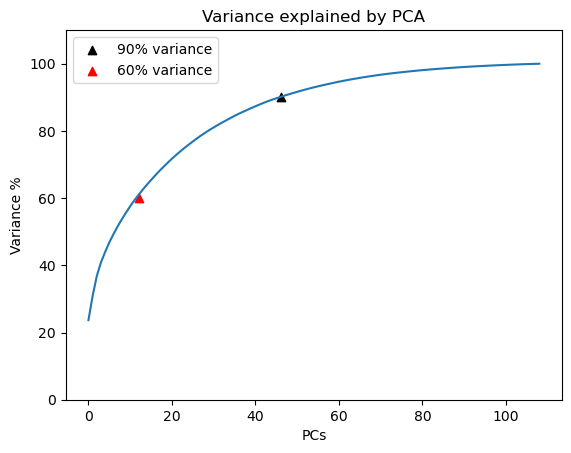

In [ ]:
%matplotlib inline
plt.plot(np.cumsum(eigval_sorted_normalised)*100)
pc_90perc = np.where(np.cumsum(eigval_sorted_normalised)>=0.9)[0][0]
pc_30perc = np.where(np.cumsum(eigval_sorted_normalised)>=0.3)[0][0]
pc_60perc = np.where(np.cumsum(eigval_sorted_normalised)>=0.6)[0][0]
plt.scatter(pc_90perc, 90, marker='^', c='k', label='90% variance')
plt.scatter(pc_60perc, 60, marker="^", c='r', label="60% variance")
print(np.sum(eigval_sorted_normalised[0:3])*100)
print("PC1(%)=", eigval_sorted_normalised[0]*100)
print("PC2(%)=", eigval_sorted_normalised[1]*100)
print("PC3(%)=", eigval_sorted_normalised[2]*100)

plt.xlabel('PCs')
plt.ylabel('Variance %')
plt.title('Variance explained by PCA')
plt.legend()
plt.ylim([0, 110])
# plt.savefig('Results_SQ/Non injected/PCA_finalpictures_SQNew/variance_PCA_20240707.svg')
plt.show()

In [ ]:
# Preprocessing step for Leave one out approach [Extended data Fig 6e]


totalunits = []
totalunitscumsum = [0]

for i in range(len(neural_S_all)):
    totalunits.append(neural_S_all[i].shape[-1])
    totalunitscumsum.append(totalunitscumsum[i]+totalunits[i])

unitactivitypermouseS = []
unitactivitypermouseQ = []
unitactivitypermouseSQ = []

for i in range(2):
    x = np.array([])
    
    x = SQ_heatmapPCA[totalunitscumsum[i]:totalunitscumsum[i+1],:]
    unitactivitypermouseSQ.append(x)
    unitactivitypermouseS.append(x)
 

print(np.sum(totalunits))

109


In [ ]:
# Preprocessing step for Leave one out approach [Extended data Fig 6e]


bigarr_SQexclusionsess_allsess = []
l_traj_stats = []
for i in range(len(unitactivitypermouseSQ)):
    bigarr_SQexclusionsess =np.array([])
    for j in range(len(unitactivitypermouseSQ)):
        if i != j:
            if len(bigarr_SQexclusionsess) == 0:
                bigarr_SQexclusionsess = unitactivitypermouseSQ[j] #np.vstack((unitactivitypermouseS[j],unitactivitypermouseQ[j])).T
            else:
                bigarr_SQexclusionsess = np.vstack((bigarr_SQexclusionsess, unitactivitypermouseSQ[j])) #np.vstack((bigarr_SQexclusionsess, np.vstack((unitactivitypermouseS[j],unitactivitypermouseQ[j])).T))
    
    bigarr_SQexclusionsess_allsess.append(bigarr_SQexclusionsess)


(54, 802)
(54, 54)
(54, 54)
Dimension of projected data:
(802, 54)
(55, 802)
(55, 55)
(55, 55)
Dimension of projected data:
(802, 55)


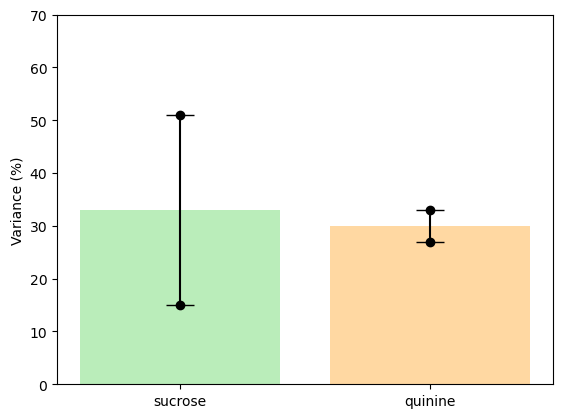

In [ ]:
# Variance explained by each trial type [Fig 5f]
total_variance_sucrose = []  
total_variance_quinine = []  

for i in range(len(bigarr_SQexclusionsess_allsess)):
    traj , eigval_normalised , PC , eigenvec , eigenval = SQ_PCA_analysis.PCA_analysis(l_data_PCA=bigarr_SQexclusionsess_allsess[i], k = 100)
   
    projected_sucrose = SQ_PCA_analysis.projectdata(PC, bigarr_SQexclusionsess_allsess[i][:,:401])
    projected_quinine = SQ_PCA_analysis.projectdata(PC, bigarr_SQexclusionsess_allsess[i][:,401:])

    variance_sucrose = np.var(projected_sucrose, axis=0)
    variance_quinine = np.var(projected_quinine, axis=0)

    total_var_sucrose = np.sum(variance_sucrose)
    total_var_quinine = np.sum(variance_quinine)

    explained_variance_ratio_sucrose = variance_sucrose / total_var_sucrose
    explained_variance_ratio_quinine = variance_quinine / total_var_quinine
    
    y = explained_variance_ratio_sucrose[0] * 100 + explained_variance_ratio_sucrose[1] * 100 + explained_variance_ratio_sucrose[2] * 100
    x = explained_variance_ratio_quinine[0] * 100 + explained_variance_ratio_quinine[1] * 100 + explained_variance_ratio_quinine[2] * 100

    total_variance_quinine.append(int(x))  
    total_variance_sucrose.append(int(y)) 

    

# Calculate mean and SEM for the accumulated data
meanPC1 = np.mean(total_variance_sucrose)
meanPC2 = np.mean(total_variance_quinine)
semPC1 = sem(total_variance_sucrose)
semPC2 = sem(total_variance_quinine)


means = [meanPC1, meanPC2]
error = [semPC1, semPC2]
colours = ['#77DD77', '#FFB347'] 
xlabels = ["sucrose", "quinine"]
x_pos = np.arange(len(xlabels))

plt.bar(x=x_pos, height=means, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color=colours)
plt.xticks(x_pos, xlabels)
plt.ylabel('Variance (%)')
plt.ylim([0, 70])


plt.scatter(np.zeros(len(total_variance_sucrose)), total_variance_sucrose, c='k')
plt.scatter(np.ones(len(total_variance_quinine)), total_variance_quinine, c='k')
plt.show()

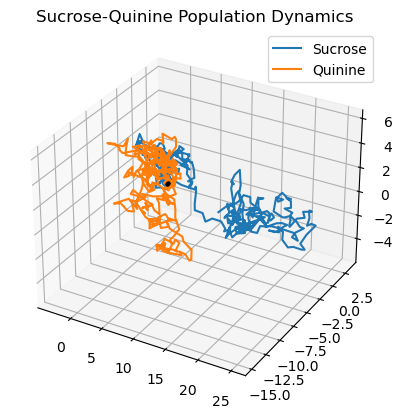

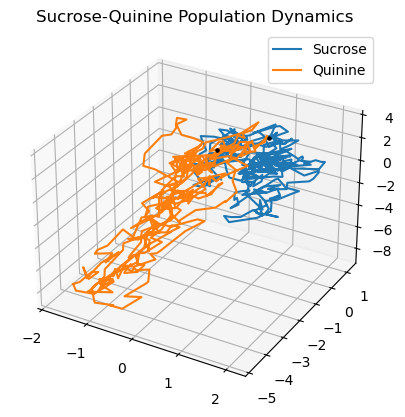

In [ ]:
#  Leave one out analysis [Extended data Fig 6e]


length_trial = 401
euclideandistanceS = []
euclideandistanceQ = []
midlength = int(l_traj_big.shape[0]/2)
l_traj_stats = []

for i in range(len(unitactivitypermouseSQ)):
    deleteeigenvalsvecs = np.arange(totalunitscumsum[i],totalunitscumsum[i+1])
    eigvec_copy = np.copy(eigvec)
    eigenval_copy = np.copy(eigval)
    num = len(deleteeigenvalsvecs)
    tot = eigvec_copy.shape[0]
    eigenvec_stats = np.delete(eigvec_copy, deleteeigenvalsvecs, axis=0) #eigvec_copy[:tot-num, :tot-num] #
    eigval_stats = np.delete(eigenval_copy, deleteeigenvalsvecs)
    idx_argsorteigval = np.argsort(eigval_stats)[::-1]
    eigenvec_stats = eigenvec_stats[:,idx_argsorteigval]
    

    l_traj_bigsinglesess = SQ_PCA_analysis.projectdata(data_mat=bigarr_SQexclusionsess_allsess[i], PC=eigenvec_stats)
  
    l_traj_stats.append(l_traj_bigsinglesess)

    ax = plt.axes(projection='3d')
    sig = 3
    x = l_traj_bigsinglesess[:length_trial,0]
    l =  x**2

    y = l_traj_bigsinglesess[:length_trial,1]
    z = l_traj_bigsinglesess[:length_trial,2]
    ax.plot(x,y,z, label="Sucrose")
    ax.scatter3D(x[0], y[0], z[0], s=5, c='k', marker='o')
    
    x = l_traj_bigsinglesess[length_trial:,0]
    y = l_traj_bigsinglesess[length_trial:,1]
    z = l_traj_bigsinglesess[length_trial:,2]
    ax.plot(x,y,z, label = "Quinine")
    ax.scatter3D(x[0], y[0], z[0], s=5, c='k', marker='o')
    
    plt.legend()
    plt.title('Sucrose-Quinine Population Dynamics')
   #  plt.savefig('Results_SQ/Non injected/PCA_finalpictures_SQNew/stats_PCA_figs/PCA_Individual_SQ_'+str(i)+'.svg')
    plt.show()
    distS = 0
    distQ = 0
    for ii in range(3):
       distS += l_traj_stats[i][:midlength,ii]**2
       distQ += l_traj_stats[i][midlength:,ii]**2
    zeropoint = int(midlength/2)

    euclideandistanceS.append(np.sum(distS)**0.5)

    euclideandistanceQ.append(np.sum(distQ)**0.5)



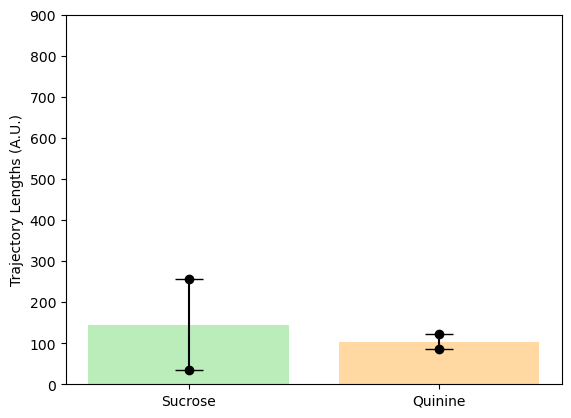

In [ ]:
# Preprocessing step for Leave one out approach: Trajectory length [Fig 5e]

meanS = np.mean(euclideandistanceS)
meanQ = np.mean(euclideandistanceQ)
semS = sem(euclideandistanceS)
semQ = sem(euclideandistanceQ)
means = [meanS, meanQ]
error = [semS, semQ]
colours = ['#77DD77', '#FFB347'] 
xlabels = ["Sucrose", "Quinine"]
x_pos = np.arange(len(xlabels))
plt.bar(x=x_pos, height=means,yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color=colours)
plt.xticks(x_pos,xlabels)
plt.ylabel('Trajectory Lengths (A.U.)')
plt.ylim([0,900])
plt.scatter(np.zeros(len(unitactivitypermouseSQ)), euclideandistanceS,c='k')
plt.scatter(np.ones(len(unitactivitypermouseSQ)), euclideandistanceQ, c='k')
# plt.savefig('Results_SQ/Non injected/PCA_finalpictures_SQNew/PCA_SQ_TrajLengths_20240707.svg')
plt.show()


In [ ]:
# Code to generate the shuffled data 
# from -5sec to 5 sec take a random number and shift (trial by trial) neural data by that much 
import random

def circularshift_persess(neural):
    st_time = -10
    ed_time = 10
    binsize = 0.025 # sec
    trialnums = neural.shape[0]
    timepointnum = neural.shape[1]
    neural_sh = np.zeros(neural.shape)
    for i in range(trialnums):
        rng = (random.random())
        rng_shift = ((rng*(ed_time -(st_time)) + st_time)) # -5 to 5 sec rng
        rng_shift_timepoints = int((rng_shift - st_time)/binsize)
        if rng_shift_timepoints == 0:
            neur = neural[i,:,:]
        else:
            neur = np.concatenate((neural[i,rng_shift_timepoints:,:],neural[i,:rng_shift_timepoints,:]), axis=0)

        neural_sh[i,:,:] = neur
    return neural_sh

def poisson_rng(neural):
    np.random.seed(100)
    st_time = -10
    ed_time = 10
    binsize = 0.025 # sec
    trialnums = neural.shape[0]
    timepointnum = neural.shape[1]
    timepointquarter = int(timepointnum/4)
    neural_sh = np.zeros(neural.shape).astype(np.float64)
    #print(timepointnum)
    fr = np.sum(neural, axis=1)/(timepointnum) # sum along time/t 
    for i in range(trialnums): # per trial
        
        for j in range(neural.shape[-1]): #per unit
            if ~np.isnan(fr[i,j]):
                summ = np.sum(neural[i,timepointquarter:-timepointquarter,j])
                t = int(timepointnum/2*30000*0.025)
                #print(summ/t)
                y = np.random.binomial(n=1, p=summ/t, size=t)
                c=int(30000*0.025)
                #print(new.shape)
                for ii in range(timepointquarter, neural.shape[1]-timepointquarter):
                    neural_sh[i,ii, j] = np.sum(y[i*c:(ii+1)*c])
            else:
                    neural_sh[i,:,j] = np.nan*np.ones(timepointnum)
    
    return neural_sh

def poisson_rng_simple(neural):
    np.random.seed(100)
    st_time = -10
    ed_time = 10
    binsize = 0.025 # sec
    trialnums = neural.shape[0]
    timepointnum = neural.shape[1]
    timepointquarter = int(timepointnum/4)
    neural_sh = np.zeros(neural.shape).astype(np.float64)

    fr = np.sum(neural, axis=1)/(timepointnum) 
    for i in range(trialnums): # per trial
        for j in range(neural.shape[-1]): #per unit
            if ~np.isnan(fr[i,j]):
                neural_sh[i,:,j] = np.random.poisson(lam=fr[i,j], size=timepointnum).astype(np.float64)
            else:
                neural_sh[i,:,j] = np.nan*np.ones(timepointnum)
   
    return neural_sh


def shuffletrialtypes(neurssh_1, neurqsh_1):
    s_num = neurssh_1.shape[0]
    q_num = neurqsh_1.shape[0]
    alltrials = np.concatenate((neurssh_1, neurqsh_1), axis=0)
    tot = s_num + q_num 
    rand_s = np.random.randint(tot, size=s_num)
    rand_q = np.random.randint(tot, size =q_num)
    neurssh = alltrials[rand_s, :,:]
    neurqsh = alltrials[rand_q,:,:]
    return neurssh, neurqsh

def shuffleddatasetgenerator(seed,totalunitscumsum, timevec, datadir = Path(r'SQ_raw')):   
    random.seed(seed)
    
    data_list = datadir.rglob('*.npz')
    
    totalunitscumsum_sh = [0]
    neural_S_all_sh = []
    neural_Q_all_sh = []
    idx_S_all_sh = []
    idx_Q_all_sh = []
    neuralshuffledtrialsS=[]
    neuralshuffledtrialsQ = []
    heatmap_S_sh = np.array([])
    heatmap_Q_sh = np.array([])
    st5sec = int(np.where(timevec <= -5)[0][-1])
    ed5sec = int(np.where(timevec >= 5)[0][0])
    for data_path in data_list:
        n = data_path.name
        if str(n)[:-13] in mouse_consider_sq:
            print(n)
        else:
            continue

        f= np.load(str(datadir)+"\\"+n, allow_pickle=True)

        neuralS = f['arr_0']
        neuralQ = f['arr_1']
       
        for i in range(neuralS.shape[1]):
            neuralS[:,i,:] = np.sum(neuralS[:,i:i+10,:], axis = 1)
            neuralQ[:,i,:] = np.sum(neuralQ[:,i:i+10,:], axis = 1)

        neurssh = poisson_rng_simple(neuralS) 
        neurqsh = poisson_rng_simple(neuralQ) 

        for i in range(neuralS.shape[1]):
            neurssh[:,i,:] = np.sum(neurssh[:,i:i+10,:], axis = 1)
            neurqsh[:,i,:] = np.sum(neurqsh[:,i:i+10,:], axis = 1)
        neuralshuffledtrialsS.append(neurssh)
        neuralshuffledtrialsQ.append(neurqsh)
        
        neural_S_all_sh.append(neurssh)
        neural_Q_all_sh.append(neurqsh)
        idx_S_all_sh.append(f['arr_2'])
        idx_Q_all_sh.append(f['arr_3'])

        Sarr_sh = np.nanmean(neurssh, axis=0).T
        Qarr_sh = np.nanmean(neurqsh, axis=0).T

       

        Sarr_sh, check_S_sh = SQ_PCA_analysis.calcAvgZscore(Sarr_sh,timevec , sendnans=True)
        Qarr_sh, check_Q_sh = SQ_PCA_analysis.calcAvgZscore(Qarr_sh,timevec , sendnans=True)
        
            
        if len(check_S_sh) != 0 or len(check_Q_sh) != 0:
        
            check_SQ_sh = np.union1d(check_S_sh, check_Q_sh)
            Sarr_sh = np.delete(Sarr_sh, check_SQ_sh, axis=0)
            Qarr_sh = np.delete(Qarr_sh, check_SQ_sh, axis=0)
            # print('deleted '+str(check_SQ_sh))

        totalunitscumsum_sh.append(totalunitscumsum_sh[-1]+Sarr_sh.shape[0])
        
        if len(heatmap_S_sh) == 0:
            heatmap_S_sh = Sarr_sh[:,st5sec:ed5sec]
            heatmap_Q_sh = Qarr_sh[:,st5sec:ed5sec]
        else:
            heatmap_S_sh = np.vstack((heatmap_S_sh,Sarr_sh[:,st5sec:ed5sec]))
            heatmap_Q_sh = np.vstack((heatmap_Q_sh,Qarr_sh[:,st5sec:ed5sec]))
    
    SQ_heatmapPCA_sh = np.hstack((heatmap_S_sh, heatmap_Q_sh))
    # plt.show()
    # plt.imshow(SQ_heatmapPCA_sh)
    # plt.show()
    if np.isnan(np.sum(SQ_heatmapPCA_sh)):
        return 0,0,0,0,0,0
    # print(np.linalg.eig(np.cov(SQ_heatmapPCA_sh)))
    l_traj_big_sh,eigval_sorted_normalised_sh, PC_sh,eigvec_sh, eigval_sh = SQ_PCA_analysis.PCA_analysis(l_data_PCA=SQ_heatmapPCA_sh)

    unitactivitypermouseSQ_sh = []
    bigarr_SQexclusionsess_allsess_sh = []

    for i in range(2):#(len(eohm_total_Q))
        x = np.array([])

        x = SQ_heatmapPCA_sh[totalunitscumsum_sh[i]:totalunitscumsum_sh[i+1],:]
        unitactivitypermouseSQ_sh.append(x)


    for i in range(len(unitactivitypermouseSQ_sh)):
        bigarr_SQexclusionsess_sh =np.array([])
        for j in range(len(unitactivitypermouseSQ_sh)):
            if i != j:
                if len(bigarr_SQexclusionsess_sh) == 0:
                    bigarr_SQexclusionsess_sh = unitactivitypermouseSQ_sh[j] #np.vstack((unitactivitypermouseS[j],unitactivitypermouseQ[j])).T
                else:
                    bigarr_SQexclusionsess_sh = np.vstack((bigarr_SQexclusionsess_sh, unitactivitypermouseSQ_sh[j])) #np.vstack((bigarr_SQexclusionsess, np.vstack((unitactivitypermouseS[j],unitactivitypermouseQ[j])).T))
        
        bigarr_SQexclusionsess_allsess_sh.append(bigarr_SQexclusionsess_sh)

    l_traj_big_sh,_, _,_,_ = SQ_PCA_analysis.PCA_analysis(l_data_PCA=SQ_heatmapPCA_sh)

    #  Leave one out analysis 

    euclideandistanceS_sh = []
    euclideandistanceQ_sh = []
    midlength = int(l_traj_big_sh.shape[0]/2)
    l_traj_stats_sh = []

    for i in range(len(unitactivitypermouseSQ)):
        deleteeigenvalsvecs_sh = np.arange(totalunitscumsum_sh[i],totalunitscumsum_sh[i+1])
        eigvec_copy_sh = np.copy(eigvec_sh)
        eigenval_copy_sh = np.copy(eigval_sh)
        num = len(deleteeigenvalsvecs_sh)
        tot = eigvec_copy_sh.shape[0]
        eigenvec_stats_sh = np.delete(eigvec_copy_sh, deleteeigenvalsvecs_sh, axis=0)
        eigval_stats_sh = np.delete(eigenval_copy_sh, deleteeigenvalsvecs_sh, axis=0)
        idx_argsorteigval_sh = np.argsort(eigval_stats_sh)[::-1]
        eigenvec_stats_sh = eigenvec_stats_sh[:,idx_argsorteigval_sh]

        l_traj_bigsinglesess_sh = SQ_PCA_analysis.projectdata(data_mat=bigarr_SQexclusionsess_allsess_sh[i], PC=eigenvec_stats_sh)
        
        l_traj_stats_sh.append(l_traj_bigsinglesess_sh)
        ax = plt.axes(projection='3d')
        sig = 3
        x = l_traj_bigsinglesess_sh[:length_trial,0]
        y = l_traj_bigsinglesess_sh[:length_trial,1]
        z = l_traj_bigsinglesess_sh[:length_trial,2]
        
        ax.plot(x,y,z, label="Sucrose")
        ax.scatter3D(x[0], y[0], z[0], s=5, c='k', marker='o')
        
        x = l_traj_bigsinglesess_sh[length_trial:,0]
        y = l_traj_bigsinglesess_sh[length_trial:,1]
        z = l_traj_bigsinglesess_sh[length_trial:,2]
        ax.plot(x,y,z, label = "Quinine")
        ax.scatter3D(x[0], y[0], z[0], s=5, c='k', marker='o')
        
        plt.legend()
        plt.title('Sucrose-Quinine Population Dynamics')
        # plt.savefig('Results_SQ/Non injected/PCA_finalpictures_SQNew/stats_PCA_figs/PCA_Individual_SQ_'+str(i)+'_sh.svg')
        plt.show()
        distS_sh = 0
        distQ_sh = 0
        
        for ii in range(3):
           distS_sh += l_traj_stats_sh[i][:midlength,ii]**2
           distQ_sh += l_traj_stats_sh[i][midlength:,ii]**2
        euclideandistanceS_sh.append(np.sum(distS_sh)**0.5)
        euclideandistanceQ_sh.append(np.sum(distQ_sh)**0.5)

    return euclideandistanceS_sh, euclideandistanceQ_sh, l_traj_big_sh, bigarr_SQexclusionsess_allsess_sh,l_traj_stats_sh, SQ_heatmapPCA_sh,neuralshuffledtrialsS, neuralshuffledtrialsQ, eigvec_sh, eigval_sh, eigval_sorted_normalised_sh

M2498_20230421.npz
M2502_20230421.npz
(109, 802)
(109, 109)
(109, 100)
Dimension of projected data:
(802, 100)
(109, 802)
(109, 109)
(109, 100)
Dimension of projected data:
(802, 100)


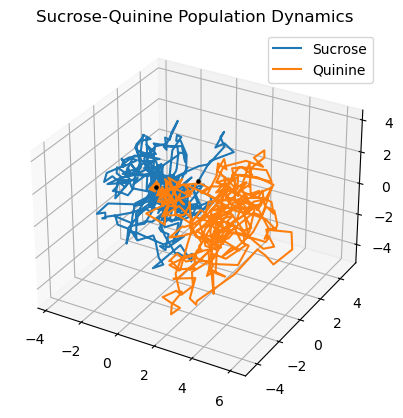

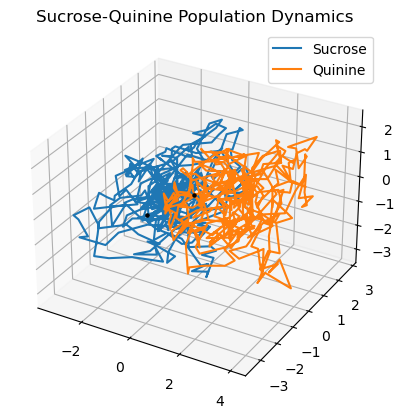

In [24]:
# length_trial = 401
num_datasets = 1
euclideandistanceS_sh_all, euclideandistanceQ_sh_all, l_traj_big_sh_all, l_traj_stats_sh_all, bigarr_sh_all= [],[],[], [], []
cc=0
for i in range(num_datasets):
    x,y, trajs_sh, big, stats_sh, bigarr_sh, neuraldataS_sh, neuraldataQ_sh, eigvec_sh, eigval_sh,eigval_sorted_normalised_sh = shuffleddatasetgenerator(10,totalunitscumsum, timevec)
    if np.sum(x) == 0:
        while np.sum(x)==0:
            cc+=1
            x,y, trajs_sh, big, stats_sh = shuffleddatasetgenerator(i*1000+cc,totalunitscumsum, timevec)
    l_traj_big_sh_all.append(trajs_sh)
    l_traj_stats_sh_all.append(stats_sh)
    bigarr_sh_all.append(big)
    euclideandistanceQ_sh_all = euclideandistanceQ_sh_all + list(y)
    euclideandistanceS_sh_all = euclideandistanceS_sh_all + list(x)

(54, 802)
(54, 54)
(54, 54)
Dimension of projected data:
(802, 54)
(55, 802)
(55, 55)
(55, 55)
Dimension of projected data:
(802, 55)


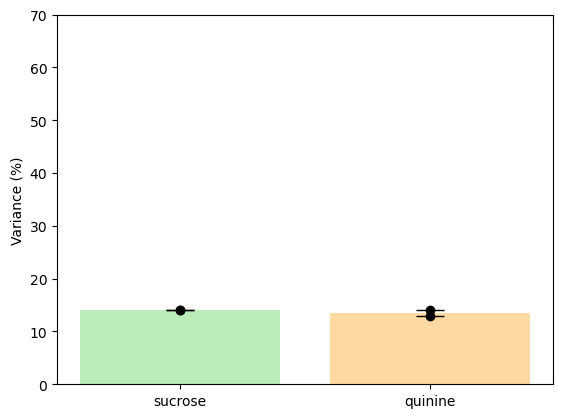

In [ ]:
# Variance explained for shuffle 
total_variance_sucrose_sh = [] 
total_variance_quinine_sh = []  

for i in range(len(big)):
    traj , eigval_normalised , PC , eigenvec , eigenval = SQ_PCA_analysis.PCA_analysis(l_data_PCA=big[i], k = 100)
    # projected_data_per_mouse.append(traj)
    projected_sucrose = SQ_PCA_analysis.projectdata(PC, big[i][:,:401])
    projected_quinine = SQ_PCA_analysis.projectdata(PC, big[i][:,401:])

    variance_sucrose = np.var(projected_sucrose, axis=0)
    variance_quinine = np.var(projected_quinine, axis=0)

    total_var_sucrose = np.sum(variance_sucrose)
    total_var_quinine = np.sum(variance_quinine)

    explained_variance_ratio_sucrose = variance_sucrose / total_var_sucrose
    explained_variance_ratio_quinine = variance_quinine / total_var_quinine
    
    y = explained_variance_ratio_sucrose[0] * 100 + explained_variance_ratio_sucrose[1] * 100 + explained_variance_ratio_sucrose[2] * 100
    x = explained_variance_ratio_quinine[0] * 100 + explained_variance_ratio_quinine[1] * 100 + explained_variance_ratio_quinine[2] * 100
    total_variance_quinine_sh.append(int(x))  
    total_variance_sucrose_sh.append(int(y)) 
  
    

# Calculate mean and SEM for the accumulated data
meanPC1 = np.mean(total_variance_sucrose_sh)
meanPC2 = np.mean(total_variance_quinine_sh)
semPC1 = sem(total_variance_sucrose_sh)
semPC2 = sem(total_variance_quinine_sh)

# Plotting
means = [meanPC1, meanPC2]
error = [semPC1, semPC2]
colours = ['#77DD77', '#FFB347'] 
xlabels = ["sucrose", "quinine"]
x_pos = np.arange(len(xlabels))

plt.bar(x=x_pos, height=means, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color=colours)
plt.xticks(x_pos, xlabels)
plt.ylabel('Variance (%)')
plt.ylim([0, 70])

# Scatter plot of individual variances
plt.scatter(np.zeros(len(total_variance_sucrose_sh)), total_variance_sucrose_sh, c='k')
plt.scatter(np.ones(len(total_variance_quinine_sh)), total_variance_quinine_sh, c='k')

plt.show()






In [26]:
len(l_traj_big_sh_all)
l_traj_sh_final = l_traj_big_sh_all[0]/num_datasets
for i in range(1,num_datasets): 
    l_traj_sh_final += l_traj_big_sh_all[i]/num_datasets

14.856247911353893


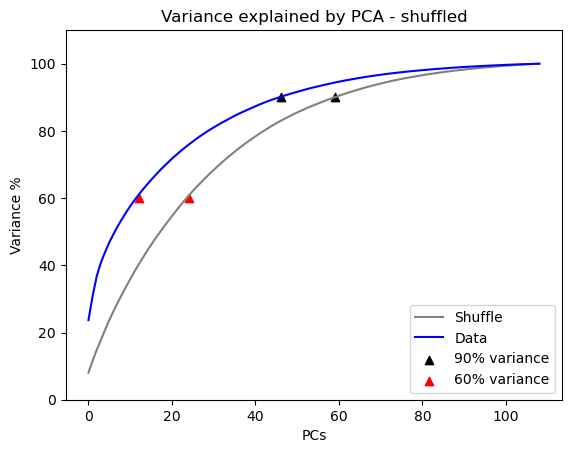

In [27]:
%matplotlib inline
plt.plot(np.cumsum(eigval_sorted_normalised_sh)*100, c='grey', label='Shuffle')
plt.plot(np.cumsum(eigval_sorted_normalised)*100, c='blue', label='Data')
pc_90perc_sh = np.where(np.cumsum(eigval_sorted_normalised_sh)>=0.9)[0][0]
pc_30perc_sh = np.where(np.cumsum(eigval_sorted_normalised_sh)>=0.3)[0][0]
pc_60perc_sh = np.where(np.cumsum(eigval_sorted_normalised_sh)>=0.6)[0][0]
plt.scatter(pc_90perc_sh, 90, marker='^', c='k', label='90% variance')
plt.scatter(pc_60perc_sh, 60, marker="^", c='r', label="60% variance")
plt.scatter(pc_90perc, 90, marker='^', c='k')
plt.scatter(pc_60perc, 60, marker="^", c='r')
print(np.sum(eigval_sorted_normalised_sh[0:3])*100)
plt.xlabel('PCs')
plt.ylabel('Variance %')
plt.title('Variance explained by PCA - shuffled')
plt.legend()
plt.ylim([0,110])
# plt.savefig('Results_SQ/Non injected/PCA_finalpictures_SQNew/variance_PCA_sh_20240707.svg')
plt.show()

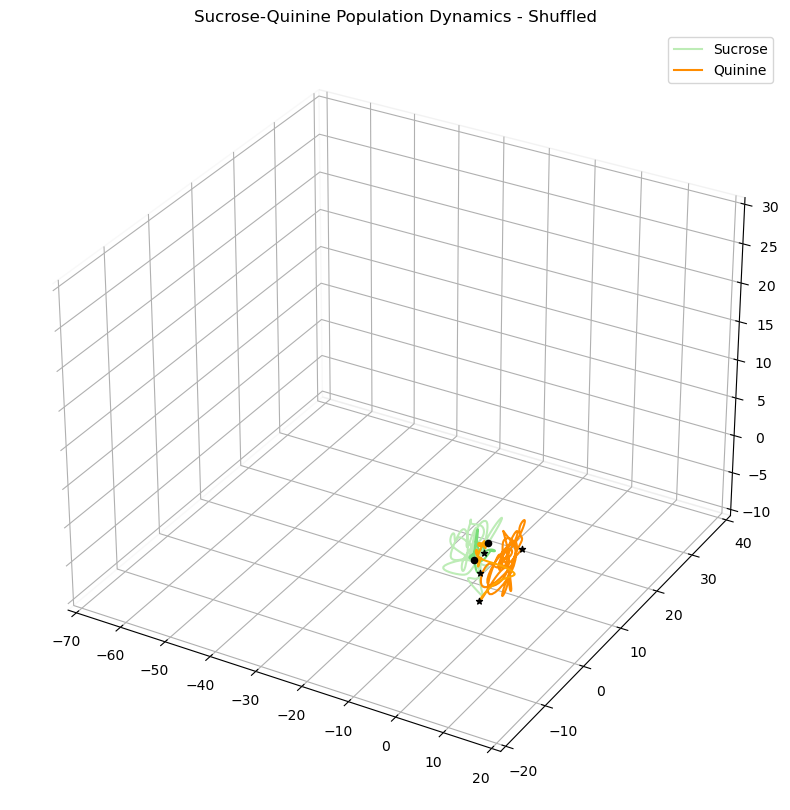

In [31]:
#l_traj_big_sh,eigval_sorted_normalised_sh, PC_sh,eigvec_sh, eigval_sh = PCA_analysis(l_data_PCA=SQ_heatmapPCA_sh)
fig = plt.figure(figsize=(10,10),facecolor='white')
ax = plt.axes(projection='3d')
mid = 101
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
sig = 3
x = gaussian_filter1d(l_traj_sh_final[:length_trial,0], sig)
y = gaussian_filter1d(l_traj_sh_final[:length_trial,1], sig)
z = gaussian_filter1d(l_traj_sh_final[:length_trial,2], sig)
ax.plot(x[mid:],y[mid:],z[mid:], label="Sucrose", color='#BDECB6')
ax.plot(x[:mid+1],y[:mid+1],z[:mid+1], color='#77DD77')
ax.scatter3D(x[0], y[0], z[0], s=20, c='k', marker='o')
ax.scatter3D(x[mid], y[mid], z[mid], s=20, c='k', marker="*")
ax.scatter3D(x[-1], y[-1], z[-1], s=20, c='k', marker="*")

x = gaussian_filter1d(l_traj_sh_final[length_trial:,0], sig)
y = gaussian_filter1d(l_traj_sh_final[length_trial:,1], sig)
z = gaussian_filter1d(l_traj_sh_final[length_trial:,2], sig)
ax.plot(x[mid:],y[mid:],z[mid:], label = "Quinine", color='darkorange')
ax.plot(x[:mid+1],y[:mid+1],z[:mid+1], color='orange')
ax.set_xlim([-70,20])
ax.set_ylim([-20,40])
ax.set_zlim([-10,30])
ax.scatter3D(x[0], y[0], z[0], s=20, c='k', marker='o')
ax.scatter3D(x[mid], y[mid], z[mid], s=20, c='k', marker="*")
ax.scatter3D(x[-1], y[-1], z[-1], s=20, c='k', marker="*")
plt.legend()
plt.title('Sucrose-Quinine Population Dynamics - Shuffled')
# plt.savefig('Results_SQ/Non injected/PCA_finalpictures_SQNew/PCA_SQ_sh_20240707.svg')
plt.show()

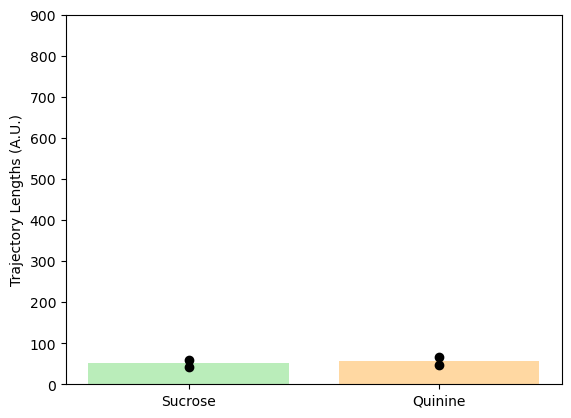

In [39]:
import warnings
warnings.filterwarnings('ignore')

def avg_stats(euclideandist, num_sess=10):
    #num_sess = 10
    num_datasets = int(len(euclideandist)/num_sess)
    euclideandist_avg = np.zeros(num_sess)
    for i in range(num_sess):
        idx = np.arange(i, len(euclideandist), num_sess)
        euclideandist_avg[i] = np.mean(np.array(euclideandist)[idx])
    return euclideandist_avg


def plot_stats(euclideandistanceS_sh, euclideandistanceQ_sh, trial):
    euclideandistanceQ_sh = (avg_stats(euclideandistanceQ_sh))
    euclideandistanceS_sh = (avg_stats(euclideandistanceS_sh))

    meanS_sh = np.nanmean(euclideandistanceS_sh)
 
    meanQ_sh = np.nanmean(euclideandistanceQ_sh)
    semS_sh = sem(euclideandistanceS_sh)
    semQ_sh = sem(euclideandistanceQ_sh)
    means_sh = [meanS_sh, meanQ_sh]
    # print(means_sh, "shhhhhhhhhhhhh")
    error_sh = [semS_sh, semQ_sh]
    xlabels = ["Sucrose", "Quinine"]
    x_pos = np.arange(len(xlabels))
    plt.bar(x=x_pos, height=means_sh,yerr=error_sh, align='center', alpha=0.5, ecolor='black', capsize=10, color=colours)
    plt.xticks(x_pos,xlabels)
    plt.ylabel('Trajectory Lengths (A.U.)')
    plt.scatter(np.zeros(len(euclideandistanceS_sh)), euclideandistanceS_sh,c='k')
    plt.scatter(np.ones(len(euclideandistanceQ_sh)), euclideandistanceQ_sh, c='k')
    plt.ylim([0,900])
    # plt.savefig(f'Results_SQ/Non injected/PCA_finalpictures_SQNew/PCA_SQ_sh_TrajLengths_statistics_{trial}20240707.svg')
    plt.show()
    

plot_stats(euclideandistanceS_sh_all, euclideandistanceQ_sh_all, trial="shuffle")

# DECODING

In [ ]:
#This is the decoding code for fig 5g 

import warnings
warnings.simplefilter('ignore')
datadir = Path(r'SQ_raw') # Path(r"C:\Users\tdhanireddy\PycharmProjects\beyeler-yoni\scripts\behavior_and_ephys_analysis\PSTHdata\Heatmaps_SQ_AllUnits") # take data from here
data_list = datadir.rglob('*.npz')

neural_S_all = []
neural_Q_all = []
idx_S_all = []
idx_Q_all = []
heatmap_S = np.array([])
heatmap_Q = np.array([])
heatmap_persess = [None]*1
st5sec = int(np.where(timevec <= -5)[0][-1])
ed5sec = int(np.where(timevec >= 5)[0][0])
mousenames = []
trialnumsS = []
trialnumsQ = []
c=0
neural_S_all_trials=[None]*2
neural_Q_all_trials =[None]*2

for data_path in data_list:
    
    flag = 0
    n = data_path.name
    if str(n)[:-13] in mouse_consider_sq:
        # print(c)
        print("mouse name",n)
    else:
        continue
    # print(n)
    mousenames.append(str(n)[:-4])
    
    f= np.load(str(datadir)+"\\"+n, allow_pickle=True)
    neural_S_all.append(f['arr_0'])

    neural_Q_all.append(f['arr_1'])
    trialnumsS.append(len(f['arr_0']))
    trialnumsQ.append(len(f['arr_1']))
    idx_S_all.append(f['arr_2'])
    idx_Q_all.append(f['arr_3'])
    neural_S_all_trials[c]=[]
    neural_Q_all_trials[c] =[]

    window = 5
    rem_S = []
    rem_Q = []
    
    for i in range(neural_S_all[c].shape[1]):
        neural_S_all[c][:,i,:] = np.sum(neural_S_all[c][:,i:i+10,:], axis = 1)
        neural_Q_all[c][:,i,:] = np.sum(neural_Q_all[c][:,i:i+10,:], axis=1)

    for i in range(neural_S_all[c].shape[0]):

        Sarr, rem = SQ_PCA_analysis.calcAvgZscore(neural_S_all[c][i,:,:].T,timevec ,sendnans=True)
        rem_S.append(rem)

        if len(rem) != 0:
            Sarr = np.delete(Sarr, rem, axis=0) #deletes units whose rem == 0 
    
        Sarr = Sarr[:,st5sec:ed5sec]#extraction of -5 to +5 (unit(eg. 61) x 401(time))
        rows_with_nan = np.any(np.isnan(Sarr), axis=1)
        rows_with_nan_indices = np.where(rows_with_nan)[0]#gets neurons with Nan values
      
        deleteeigenvalsvecs = np.arange(totalunitscumsum[c],totalunitscumsum[c+1])
        if len(rem) != 0:
            deleteeigenvalsvecs = np.delete(deleteeigenvalsvecs,rem)

        if len(rows_with_nan_indices)!= 0:
            deleteeigenvalsvecs = np.delete(deleteeigenvalsvecs,rows_with_nan_indices)
            Sarr = np.delete(Sarr, rows_with_nan_indices, axis=0)#deletes nan rows from both Sarr, and eigenvec to be considered

       
        eigvec_copy = np.copy(eigvec)
        eigenval_copy = np.copy(eigval)
        num = len(deleteeigenvalsvecs)
        tot = eigvec_copy.shape[0]
        eigenvec_stats = eigvec_copy[deleteeigenvalsvecs,:]
        eigval_stats = eigenval_copy[deleteeigenvalsvecs]
        idx_argsorteigval = np.argsort(eigval_stats)[::-1]
        eigenvec_stats = eigenvec_stats[:,idx_argsorteigval] 
        x = SQ_PCA_analysis.projectdata(data_mat=Sarr, PC=eigenvec_stats)[:,:3]
        neural_S_all_trials[c].append(x)
    
   
         
    for i in range(neural_Q_all[c].shape[0]):
        
        Qarr, rem = SQ_PCA_analysis.calcAvgZscore(neural_Q_all[c][i,:,:].T,timevec , sendnans=True)
        rem_Q.append(rem)

        if len(rem) != 0:
            Qarr = np.delete(Qarr, rem, axis=0)
        
        Qarr = Qarr[:,st5sec:ed5sec]
        rows_with_nan = np.any(np.isnan(Qarr), axis=1)
        rows_with_nan_indices = np.where(rows_with_nan)[0]

        deleteeigenvalsvecs = np.arange(totalunitscumsum[c],totalunitscumsum[c+1])
        if len(rem) != 0:
                deleteeigenvalsvecs = np.delete(deleteeigenvalsvecs, rem)

        if len(rows_with_nan_indices)!= 0:
            deleteeigenvalsvecs = np.delete(deleteeigenvalsvecs,rows_with_nan_indices)
            Qarr = np.delete(Qarr, rows_with_nan_indices, axis=0)

        eigvec_copy = np.copy(eigvec)
        eigenval_copy = np.copy(eigval)
        num = len(deleteeigenvalsvecs)
        tot = eigvec_copy.shape[0]
        eigenvec_stats = eigvec_copy[deleteeigenvalsvecs,:]
        eigval_stats = eigenval_copy[deleteeigenvalsvecs]
        idx_argsorteigval = np.argsort(eigval_stats)[::-1]
        eigenvec_stats = eigenvec_stats[:,idx_argsorteigval]
        neural_Q_all_trials[c].append(SQ_PCA_analysis.projectdata(data_mat=Qarr, PC=eigenvec_stats)[:,:3])

   
    c+=1

mouse name M2498_20230421.npz
mouse name M2502_20230421.npz


In [44]:
# shuffled datasets 

neural_S_all_trials_sh=[None]*2
neural_Q_all_trials_sh =[None]*2

for c in range(len(neuraldataQ_sh)):
    neural_S_all_trials_sh[c]=[]
    neural_Q_all_trials_sh[c] =[]
    for i in range(neuraldataS_sh[c].shape[0]):
        Sarr, rem = SQ_PCA_analysis.calcAvgZscore(neuraldataS_sh[c][i,:,:].T,timevec , sendnans=True)
        rem_S.append(rem)
        if len(rem) != 0:
            Sarr = np.delete(Sarr, rem, axis=1)
        Sarr = Sarr[:,st5sec:ed5sec]

        rows_with_nan = np.any(np.isnan(Sarr), axis=1)
        rows_with_nan_indices = np.where(rows_with_nan)[0]
        deleteeigenvalsvecs = np.arange(totalunitscumsum[c],totalunitscumsum[c+1])

        if len(rem) != 0:
            deleteeigenvalsvecs = np.delete(deleteeigenvalsvecs, totalunitscumsum[c]+rem)
            print(len())
        if len(rows_with_nan_indices)!= 0:
            deleteeigenvalsvecs = np.delete(deleteeigenvalsvecs,rows_with_nan_indices)
            Sarr = np.delete(Sarr, rows_with_nan_indices, axis=0)    
      
        eigvec_copy = np.copy(eigvec_sh)
        eigenval_copy = np.copy(eigval_sh)
        num = len(deleteeigenvalsvecs)
        tot = eigvec_copy.shape[0]
       
        eigenvec_stats = eigvec_copy[deleteeigenvalsvecs,:]
        eigval_stats = eigenval_copy[deleteeigenvalsvecs]
        idx_argsorteigval = np.argsort(eigval_stats)[::-1]
        eigenvec_stats = eigenvec_stats[:,idx_argsorteigval]
       
        
        neural_S_all_trials_sh[c].append(SQ_PCA_analysis.projectdata(data_mat=Sarr, PC=eigenvec_stats)[:,:3])

    for i in range(neuraldataQ_sh[c].shape[0]):
        Qarr, rem = SQ_PCA_analysis.calcAvgZscore(neuraldataQ_sh[c][i,:,:].T,timevec , sendnans=True)
        rem_Q.append(rem)
        
        if len(rem) != 0:
            Qarr = np.delete(Qarr, rem, axis=1)
        
      
        Qarr = Qarr[:,st5sec:ed5sec]
        rows_with_nan = np.any(np.isnan(Qarr), axis=1)
        rows_with_nan_indices = np.where(rows_with_nan)[0]

        deleteeigenvalsvecs = np.arange(totalunitscumsum[c],totalunitscumsum[c+1])
        if len(rem) != 0:
             deleteeigenvalsvecs = np.delete(deleteeigenvalsvecs, totalunitscumsum[c]+rem)
        if len(rows_with_nan_indices)!= 0:
            deleteeigenvalsvecs = np.delete(deleteeigenvalsvecs,rows_with_nan_indices)
            Qarr = np.delete(Qarr, rows_with_nan_indices, axis=0)

        eigvec_copy = np.copy(eigvec_sh)
        eigenval_copy = np.copy(eigval_sh)
        num = len(deleteeigenvalsvecs)
        tot = eigvec_copy.shape[0]
        eigenvec_stats = eigvec_copy[deleteeigenvalsvecs,:]
        eigval_stats = eigenval_copy[deleteeigenvalsvecs]
        idx_argsorteigval = np.argsort(eigval_stats)[::-1]
        eigenvec_stats = eigenvec_stats[:,idx_argsorteigval]
    
        neural_Q_all_trials_sh[c].append(SQ_PCA_analysis.projectdata(data_mat=Qarr, PC=eigenvec_stats)[:,:3])
    
    

In [46]:
# 5 fold cross verification 
# since the number of trials are low, we do leave one out method for each svm run 
# ensure the number of trials per trialtype remains the same 
# create 5 datasets:
#Bootstrapping - Datasets 100
num_datasets = 100

def dataset_gen(neural_S_all_trials, neural_Q_all_trials, num_datasets=100):
    ignoresess=[]
    np.random.seed(42)
    l_traj_datasets = [None]*num_datasets
    mintrialnum = 0

    for i in range(2):
        
        neural_S_all_trials[i] = np.array(neural_S_all_trials[i])
        num_trials_S = (neural_S_all_trials[i]).shape[0]
        neural_Q_all_trials[i] = np.array(neural_Q_all_trials[i])
        num_trials_Q = (neural_Q_all_trials[i]).shape[0]
        
        lens = np.array([num_trials_S, num_trials_Q])
        trialnumm = np.min(lens)
    
        if trialnumm == 1:
            ignoresess.append(i)
            continue

        if i == 0:
            mintrialnum = trialnumm

        if mintrialnum>trialnumm:
            mintrialnum = trialnumm

    for j in range(num_datasets):
        for i in range(2):
            if i in ignoresess:
                continue
            if i == 0:
                l_traj_datasets[j] = []
            neural_S_all_trials[i] = np.array(neural_S_all_trials[i])
            num_trials_S = (neural_S_all_trials[i]).shape[0]
            
            neural_Q_all_trials[i] = np.array(neural_Q_all_trials[i])
            num_trials_Q = (neural_Q_all_trials[i]).shape[0]
    
        
            idx_S_bootstrap = np.random.permutation(np.arange(0, num_trials_S))[:mintrialnum] #np.random.randint(num_trials_S, size=mintrialnum)
        
            idx_Q_bootstrap = np.random.permutation(np.arange(0, num_trials_Q))[:mintrialnum]#np.random.randint(num_trials_Q, size = mintrialnum)


            for k in range(mintrialnum):
                concat = np.concatenate((neural_S_all_trials[i][idx_S_bootstrap[k],:,:].squeeze(),neural_Q_all_trials[i][idx_Q_bootstrap[k],:,:].squeeze()), axis=0)
                l_traj_datasets[j].append(concat)

                

    return l_traj_datasets, ignoresess

l_traj_datasets, ignoresess = dataset_gen(neural_Q_all_trials=neural_Q_all_trials, neural_S_all_trials=neural_S_all_trials)
l_traj_datasets_sh, ignoresess_sh = dataset_gen(neural_Q_all_trials=neural_Q_all_trials_sh, neural_S_all_trials=neural_S_all_trials_sh)

In [47]:
datasets = []
for dataset in l_traj_datasets:
    reshaped_data = []
    for sub_element in dataset:
        reshaped_sub_element = np.array(sub_element).reshape(802, 3)
        reshaped_data.append(reshaped_sub_element)
    reshaped_data = np.stack(reshaped_data)  # Shape will be (40, 802, 3)
    datasets.append(reshaped_data)

In [48]:
datasets_sh = []
for dataset in l_traj_datasets_sh:
    reshaped_data = []
    for sub_element in dataset:
        reshaped_sub_element = np.array(sub_element).reshape(802, 3)
        reshaped_data.append(reshaped_sub_element)
    reshaped_data = np.stack(reshaped_data)  # Shape will be (40, 802, 3)
    datasets_sh.append(reshaped_data)

In [ ]:
#This is the decoder function[Fig 5g]

def decoder_new(l_traj, num_trials=2):
    l_traj = np.array(l_traj) # trials, time, units
    len_trial = int((l_traj).shape[1]/2)
    trajectories = np.zeros((l_traj.shape[0]*2,len_trial, l_traj.shape[-1]))
    labels = np.zeros(l_traj.shape[0]*2)

    for i in range(l_traj.shape[0]):
        trajectories[i*2, :, : ] = l_traj[i,:len_trial,:]
        labels[i*2] = 0 
        trajectories[i*2+1, :, :] = l_traj[i,len_trial,:]
        labels[i*2+1] = 1
            
    r_square_full = []
    for i in range(len_trial):
        train_x, test_x, train_y, test_y = train_test_split(trajectories[:,i,:].squeeze(),labels, test_size=0.2, random_state=50)
        #print('SVM')
        reg = svm.SVC(kernel= "linear", C=1.0)
        reg.fit(train_x, train_y)
        yhat = reg.predict(test_x)
        confusion_matrix = sklearn.metrics.confusion_matrix(test_y, yhat)
        r_squared = np.trace(confusion_matrix)/np.sum(confusion_matrix)
        r_square_full.append(r_squared)
    return gaussian_filter1d(r_square_full, sigma=2)


In [ ]:
# random.seed(100)
adjusted_r_squared, adjusted_r_squared_sh = [None]*num_datasets, [None]*num_datasets
fig, ax = plt.subplots()
t_show = np.arange(-5,6,1)
ticknum = len(t_show)
idx_ticks = np.linspace(0, int((datasets[i].shape[1])/2), ticknum)  #
for i in range(int(num_datasets)):
    # print(i)
    adjusted_r_squared[i] = np.array(decoder_new(l_traj=datasets[i], num_trials=2))
    adjusted_r_squared_sh[i] = np.array(decoder_new(l_traj=datasets_sh[i], num_trials=2))


In [52]:
adjusted_r_squared = np.array(adjusted_r_squared)*100
adjusted_r_squared_sh = np.array(adjusted_r_squared_sh)*100


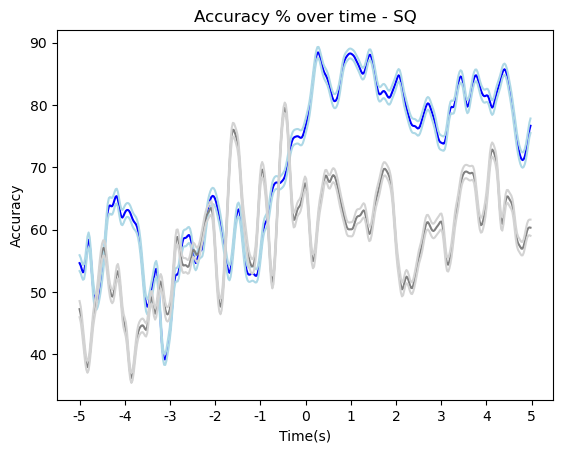

In [ ]:

time_series_length = datasets[0].shape[1]/2  
t_show = np.arange(-5, 6, 1)
ticknum = len(t_show)
idx_ticks = np.linspace(0, time_series_length , ticknum)
mean_adj = np.mean(adjusted_r_squared, axis=0)
stdd_adj = sem(adjusted_r_squared, axis=0)

mean_adj_sh = np.mean(adjusted_r_squared_sh, axis=0)
stdd_adj_sh = sem(adjusted_r_squared_sh, axis=0)

fig, ax = plt.subplots()

ax.plot(mean_adj, c='blue')
ax.plot(mean_adj + stdd_adj, c='lightblue')
ax.plot(mean_adj - stdd_adj, c='lightblue')
ax.plot(mean_adj_sh, c='grey')
ax.plot(mean_adj_sh + stdd_adj_sh, c='lightgrey')
ax.plot(mean_adj_sh - stdd_adj_sh, c='lightgrey')

ax.set_title("Accuracy % over time - SQ")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Time(s)")
ax.set_xticks(idx_ticks)
ax.set_xticklabels(t_show)
plt.show()